In [172]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import imageio
from skimage import img_as_float32
from natsort import natsorted
from skimage.color import rgb2hsv
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from time import time

path_pairs = list(zip(
    natsorted(glob('../puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('../puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])
SCALE = 0.25

imgs = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in imgs
])
msks = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in msks
])

msks[msks>0.5] = 1.
msks[msks<0.5] = 0

In [2]:
def gaussian_filter(x, y, sigma):
    return (1 / (2 * np.pi * sigma ** 2)) * np.exp(
        -1 * (x ** 2 + y ** 2) / (2 * sigma ** 2)
    )

def DoG_filter(x, y, sigma, K):
    gaussian = gaussian_filter(x, y, sigma)
    return gaussian - 1 / (2 * np.pi * (K ** 2) * (sigma ** 2)) * np.exp(
        -1 * (x ** 2 + y ** 2) / (2 * (K ** 2) * (sigma ** 2))
    )

def create_filter(shape, function, sigma, K=None):
    if K:
        return np.fromfunction(
            lambda x, y: function(
                x - int(shape[0] / 2), y - int(shape[1] / 2), sigma, K
            ),
            (shape[0], shape[1]),
            dtype=float,
        )

    return np.fromfunction(
        lambda x, y: function(x - int(shape[0] / 2), y - int(shape[1] / 2), sigma),
        (shape[0], shape[1]),
        dtype=float,
    )

DoG = create_filter([49, 49], DoG_filter, sigma=3, K=2)

In [3]:
def min_max_stretch(f):
    a = f.copy()
    if len(f.shape) == 3:
        channels = f.shape[2]
        for i in range(channels):
            a[:, :, i] = (f[:, :, i] - f[:, :, i].min()) / (
                f[:, :, i].max() - f[:, :, i].min()
            )
    else:
        a = (f - f.min()) / (f.max() - f.min())
    return a

In [4]:
rgb_DoG_imgs = []
hsv_imgs = []
for img in imgs:
    hsv = rgb2hsv(img)
    hsv_imgs.append(hsv)
    dog = min_max_stretch(cv2.filter2D(img, -1, DoG))
    rgb_dog = np.dstack((img, dog))
    rgb_DoG_imgs.append(rgb_dog)

In [5]:
rgb_DoG_imgs = np.array(rgb_DoG_imgs)
hsv_imgs = np.array(hsv_imgs)

In [6]:
rgb_imgs_train, rgb_imgs_test, msks_train, msks_test = train_test_split(
    imgs, msks, test_size=0.15, random_state=42)

rgb_DoG_imgs_train, rgb_DoG_imgs_test = train_test_split(rgb_DoG_imgs, test_size=0.15, random_state=42)

hsv_imgs_train, hsv_imgs_test = train_test_split(hsv_imgs, test_size=0.15, random_state=42)

In [178]:
class GMM:
    def __init__(self, K, num_features):
        self.K = K
        self.lambd = np.ones(K)/K
        
        self.num_features = num_features
        self.mean = np.random.random((K, num_features))
        
        self.cov = np.random.random((K,num_features,num_features))

        self.prevent_singular = np.zeros((K,num_features,num_features))
        for k in range(K):
            self.prevent_singular[k] = 1e-7*np.eye(num_features)
            self.cov[k] *= self.cov[k].T
            self.cov[k] += 1e+4*np.eye(num_features)
    
    def expectation(self, X):
        #make it self.R
        R = []
        for k in range(self.K):
            r_k_numerator = self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
            R.append(r_k_numerator)
        
        R = np.array(R).T    
        log_likelihood =  np.sum(np.log(np.sum(R, axis = 1)))
        R = R/(R.sum(axis = 1, keepdims = 1))
        
        return R, log_likelihood
    
    
    def maximisation(self, X, R):
        
        sum_r_ik = np.sum(R, axis = 0)
        self.lambd = sum_r_ik/np.sum(R)
        
        self.mean = R.T @ X / sum_r_ik.reshape(-1,1) #lp
        
        for k in range(self.K):
            self.cov[k] = (R[:,k]*(X - self.mean[k]).T @ (X - self.mean[k])) / sum_r_ik[k]
            self.cov = np.nan_to_num(self.cov) + self.prevent_singular
    
    def fit(self, X, max_iters, min_iters, converg_val):
        
        log_likelihood = 0 
        for i in range(max_iters):
            old_log_likelihood = log_likelihood
            R , log_likelihood = self.expectation(X)
            self.maximisation(X,R)
            change = np.abs(old_log_likelihood - log_likelihood)
            if change < converg_val and i > min_iters:
                break
                
    
    def predict(self, X):
        summ=0 
        for k in range(self.K):
            summ += self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
        return summ
    
    def predict_single_component(self, X, k):
        return self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
        

In [56]:
def k_fold_cv(X, num_folds = 5, shuffle = False, random_seed = 42):
    if shuffle:
        np.random.seed(seed = random_seed)
        idxs = np.random.permutation(X.shape[0])
    else:
        idxs = np.arange(X.shape[0])
    
    folds = np.array_split(idxs, num_folds)
    
    return folds
    
def get_train_val_idx(folds, val_fold_num):
    val_idx = folds[val_fold_num]
    
    train_idx = np.array([0])   
    for i in range(len(folds)):
        if i != val_fold_num:
            train_idx = np.append(train_idx, folds[i])
    
    train_idx = train_idx[1:]
    
    return train_idx, val_idx


In [57]:
def train(X,y, lambd=0.4, num_gaussians_back = 4, num_gaussians_fore = 4):
    
    gmm_back = GMM(num_gaussians_back, X.shape[1])
    gmm_back.fit(X[y<0.5], max_iters = 100, min_iters = 10, converg_val = 2) 
    
    gmm_fore = GMM(num_gaussians_fore, X.shape[1])
    gmm_fore.fit(X[y>0.5], max_iters = 100,  min_iters = 10, converg_val = 2)
    
    return gmm_back, gmm_fore

In [173]:
def dice(y_true, y_pred):
    
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    im_sum = y_true.sum() + y_pred.sum()

    # Compute Dice coefficient
    intersection = np.logical_and(y_true, y_pred)

    return 2. * intersection.sum() / im_sum

def pixel_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.uint8).flatten()
    y_pred = np.asarray(y_pred).astype(np.uint8).flatten()
    return accuracy_score(y_true, y_pred)


def iou(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def roc_auc(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool).flatten()
    y_pred = np.asarray(y_pred).astype(bool).flatten()
    return roc_auc_score(y_true, y_pred)

In [185]:
def plot_predictions(y_pred, plot_name=None, save=False): 
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
    ax = axes.flatten()
    for i in range(y_pred.shape[0]):
        ax[i].imshow(y_pred[i], cmap="gray")
        ax[i].axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(f"{plot_name}.png")
    plt.show()

In [11]:
num_folds = 5
folds = k_fold_cv(rgb_imgs_train,num_folds = num_folds)
lambd = 0.4

train_sets = ['rgb', 'rgb_dog', 'hsv']
num_components = [2,3,4]

fold_hyps = []

for i in range(num_folds):
    runs = []
    for dataset in train_sets:
        for num_gaussians_fore in num_components:
            for num_gaussians_back in num_components:
            
                if dataset == 'rgb':
                    train_set = rgb_imgs_train
                elif dataset == 'rgb_dog':
                    train_set = rgb_DoG_imgs_train
                else:
                    train_set = hsv_imgs_train
            
                train_idx, val_idx = get_train_val_idx(folds, val_fold_num = i)

                imgs_train_fold = train_set[train_idx].reshape(-1,train_set.shape[3])
                msks_train_fold = msks_train[train_idx].reshape(-1)

                imgs_val_fold = train_set[val_idx].reshape(-1,train_set.shape[3])
                msks_val_fold = msks_train[val_idx].reshape(-1)

                gmm_back, gmm_fore = train(imgs_train_fold,msks_train_fold, num_gaussians_fore=num_gaussians_fore, 
                               num_gaussians_back=num_gaussians_back)
                
                back = gmm_back.predict(imgs_val_fold)
                fore = gmm_fore.predict(imgs_val_fold)
                
                y_prob = (lambd * fore) / ((lambd * fore) + ((1 - lambd) * back))

                y_pred = (y_prob>0.5).astype(np.float32)
                
                dice_val = dice(msks_val_fold, y_pred)
                accuracy = pixel_accuracy(msks_val_fold, y_pred)
                iou_val = iou(msks_val_fold, y_pred)
                
                hyps = [dataset, num_gaussians_fore, num_gaussians_back]
                results = [dice_val, accuracy, iou_val]
                run = {'hyps':hyps, 'results': results}
                print(run)
                runs.append(run)
    fold_hyps.append(runs)
                

{'hyps': ['rgb', 2, 2], 'results': [0.8524524419800875, 0.9122746785481771, 0.7428471578563506]}
{'hyps': ['rgb', 2, 3], 'results': [0.8326455871393591, 0.8985137939453125, 0.7132757438239629]}
{'hyps': ['rgb', 2, 4], 'results': [0.8330841113486694, 0.8992869059244791, 0.7139195887644575]}
{'hyps': ['rgb', 3, 2], 'results': [0.8481558135988323, 0.9102935791015625, 0.7363459603410578]}
{'hyps': ['rgb', 3, 3], 'results': [0.8294534671688338, 0.8972549438476562, 0.7086035829457026]}
{'hyps': ['rgb', 3, 4], 'results': [0.8277054202536411, 0.8964106241861979, 0.706055828077552]}
{'hyps': ['rgb', 4, 2], 'results': [0.851712556414652, 0.9125645955403646, 0.7417241747025578]}
{'hyps': ['rgb', 4, 3], 'results': [0.8337241945975555, 0.9000879923502604, 0.7148602335190037]}
{'hyps': ['rgb', 4, 4], 'results': [0.8319134120236242, 0.8992741902669271, 0.7122018355375976]}
{'hyps': ['rgb_dog', 2, 2], 'results': [0.8637203771416865, 0.9206034342447916, 0.7601301297377807]}
{'hyps': ['rgb_dog', 2, 3], 

{'hyps': ['rgb', 3, 2], 'results': [0.9631770280205866, 0.9805933634440104, 0.9289696062402742]}
{'hyps': ['rgb', 3, 3], 'results': [0.9665868318515379, 0.9823760986328125, 0.9353343480065625]}
{'hyps': ['rgb', 3, 4], 'results': [0.9657978294383698, 0.9817937215169271, 0.9338578635102718]}
{'hyps': ['rgb', 4, 2], 'results': [0.9686798262888945, 0.9836781819661459, 0.9392619779783752]}
{'hyps': ['rgb', 4, 3], 'results': [0.969565417714002, 0.98431396484375, 0.940928647370356]}
{'hyps': ['rgb', 4, 4], 'results': [0.9687698128643011, 0.9835993448893229, 0.9394312006663758]}
{'hyps': ['rgb_dog', 2, 2], 'results': [0.9476252749510224, 0.9719696044921875, 0.900463734442995]}
{'hyps': ['rgb_dog', 2, 3], 'results': [0.948520300766846, 0.9721628824869791, 0.9020814205529631]}
{'hyps': ['rgb_dog', 2, 4], 'results': [0.9451233169906175, 0.9704081217447916, 0.8959562119567782]}
{'hyps': ['rgb_dog', 3, 2], 'results': [0.9517675539939753, 0.9740549723307291, 0.9079737587024711]}
{'hyps': ['rgb_dog',

In [30]:
fold_hyps_avg = []
for runs in fold_hyps[0]:
    fold_hyps_avg.append({'hyps': runs['hyps'], 'results': np.array(runs['results'])/5})

for i in range(1, len(fold_hyps)):
    for j in range(len(fold_hyps[i])):
        fold_hyps_avg[j]['results'] += np.array(fold_hyps[i][j]['results'])/5

In [33]:
highest_dice = fold_hyps_avg[0]
highest_accuracy = fold_hyps_avg[0]
highest_iou = fold_hyps_avg[0]
for hyps in fold_hyps_avg:
    if hyps['results'][0]>highest_dice['results'][0]:
        highest_dice = hyps
    if hyps['results'][1]>highest_accuracy['results'][1]:
        highest_accuracy = hyps
    if hyps['results'][2]>highest_iou['results'][2]:
        highest_iou = hyps

In [37]:
print(highest_dice)
print(highest_accuracy)
print(highest_iou)

{'hyps': ['hsv', 3, 3], 'results': array([0.95247713, 0.97543538, 0.90982547])}
{'hyps': ['hsv', 3, 3], 'results': array([0.95247713, 0.97543538, 0.90982547])}
{'hyps': ['hsv', 3, 3], 'results': array([0.95247713, 0.97543538, 0.90982547])}


In [59]:
hsv_imgs_train_flat = hsv_imgs_train.reshape(-1,hsv_imgs_train.shape[3])
msks_train_flat = msks_train.reshape(-1)
hsv_imgs_test_flat = hsv_imgs_test.reshape(-1,hsv_imgs_test.shape[3])
msks_test_flat = msks_test.reshape(-1)

In [179]:
start = time()
gmm_back, gmm_fore = train(hsv_imgs_train_flat,msks_train_flat, num_gaussians_fore = 3, 
               num_gaussians_back = 3)
train_time = time() - start 

In [191]:
start = time()
back = gmm_back.predict(hsv_imgs_test_flat)
fore = gmm_fore.predict(hsv_imgs_test_flat)

lambd =0.4
y_prob = (lambd * fore) / ((lambd * fore) + ((1 - lambd) * back))

y_pred = (y_prob>0.5).astype(np.float32)
inference_time = time() - start 

predicted_images = y_pred.reshape(msks_test.shape)

dice_val = dice(msks_test_flat, y_pred)
accuracy = pixel_accuracy(msks_test_flat, y_pred)
iou_val = iou(msks_test_flat, y_pred)
roc_auc_val = roc_auc(msks_test_flat, y_pred)

results of GMM on test set:
dice:  0.9763019767717948
accuracy:  0.9872945149739584
Intersection of Union:  0.9537011448874851
ROC AUC:  0.9816904467617139
Training time:  28.786713123321533
Inference time:  0.11961603164672852


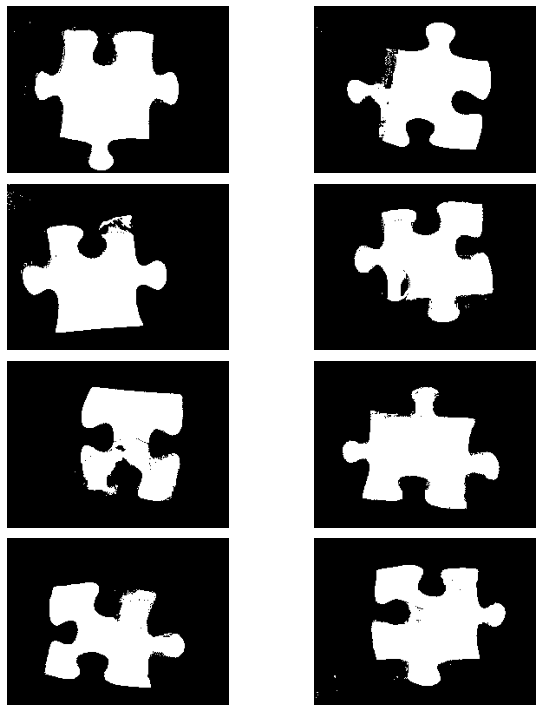

In [193]:
print('results of GMM on test set:')
print('dice: ',dice_val)
print('accuracy: ', accuracy)
print('Intersection of Union: ',iou_val)
print('ROC AUC: ',roc_auc_val)
print('Training time: ', train_time)
print('Inference time: ', inference_time)
plot_predictions(predicted_images, plot_name = "GMM_predictions", save=True)

In [181]:
def train_old_model(X,y):
    back_X = X[y<0.5]
    fore_X = X[y>0.5]
    
    back_mean = back_X.mean(axis=0)
    back_cov = np.cov(back_mean)
    
    fore_mean = fore_X.mean(axis=0)
    fore_cov = np.cov(fore_mean)
    

    return back_mean, back_cov, fore_mean, fore_cov

In [182]:
start = time()

back_mean, back_cov, fore_mean, fore_cov = train_old_model(hsv_imgs_train_flat,msks_train_flat)

train_time_old = time() -start

In [183]:
start = time()

back = multivariate_normal.pdf(hsv_imgs_test_flat, back_mean, back_cov, allow_singular=True)
fore = multivariate_normal.pdf(hsv_imgs_test_flat, fore_mean, fore_cov, allow_singular=True)

lambd =0.4
y_prob = (lambd * fore) / ((lambd * fore) + ((1 - lambd) * back))

y_pred = (y_prob>0.5).astype(np.float32)

inference_time_old = time() -start

preds = y_pred.reshape(msks_test.shape)

In [184]:
dice_val = dice(msks_test_flat, y_pred)
accuracy = pixel_accuracy(msks_test_flat, y_pred)
iou_val = iou(msks_test_flat, y_pred)
roc_auc_val = roc_auc(msks_test_flat, y_pred)

print('results of previous single gaussian method on test set:')
print('dice: ',dice_val)
print('accuracy: ', accuracy)
print('Intersection of Union: ',iou_val)
print('ROC AUC: ',roc_auc_val)
print('Training time: ', train_time_old)
print('Inference time: ', inference_time_old)

results of previous single gaussian method on test set:
dice:  0.9008371745085313
accuracy:  0.9554367065429688
Intersection of Union:  0.8195666316368914
ROC AUC:  0.9101872666954045
Training time:  0.06400418281555176
Inference time:  0.05035042762756348
